In [1]:
import string
import pandas as pd
from collections import Counter
import numpy as np
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Import du dataset

In [2]:
df = pd.read_csv('./new_tags.csv')
df.rename(columns={'Unnamed: 0' : 'Title'}, inplace=True)
df.head(10)

Title  \
0  calling .net web service (wse 2/3, ws-security...   
1                    dynamic alphabetical navigation   
2  how to fix circle and rectangle overlap in col...   
3  how do you deal with transport-level errors in...   
4  how to deploy a java ee application in the ama...   
5  what is the equivalent of perl's (<>) in pytho...   
6      why declare a local function static in c# 8.0   
7  asp.net custom validator client side & server ...   
8                ruby equivalent for python's "try"?   
9               asp.net custom controls - composites   

                                                Body        Id  \
0  <p>I need to call a web service written in .NE...     16451   
1  <p>I'm using <code>ColdFusion</code> to return...     16458   
2  <p>Since in the digital world a real collision...  18704999   
3  <p>Every now and then in a high volume .NET ap...     16610   
4  <p>Here's the thing: I need to take a certain ...   4042477   
5  <p>In Perl one uses:</p>\n\n<pre><code>while (...   4554819   
6  <p>In C# 8.0, <a href="https://learn.microsoft...  58745614   
7  <p>This has not happened to me before, but for...    701029   
8  <p>I'm trying to convert some Python code into...  18705373   
9  <h2>Summary</h2>\n<p>Hi All,<br />\nOK, furthe...     17532   

                                                Tags  Score  ViewCount  \
0              <java><.net><axis2><ws-security><wse>     23      14052   
1        <javascript><jquery><sql><html><coldfusion>      9       3283   
2  <java><collision-detection><physics><collision...     10      12806   
3   <c#><sql-server><tsql><ado.net><sql-server-2000>     33      25173   
4  <java><jakarta-ee><amazon-ec2><cloud><cloud-ho...     22      19503   
5  <python><perl><file-io><file><command-line-arg...      7        881   
6        <c#><.net><static><c#-8.0><local-functions>     22       4658   
7   <c#><.net><asp.net><validation><customvalidator>     75     261598   
8  <python><python-3.x><ruby><try-catch><language...     72      47824   
9       <c#><.net><asp.net><user-controls><controls>     19       4164   

   AnswerCount  FavoriteCount  
0            5            0.0  
1            5            0.0  
2            3            0.0  
3           11            0.0  
4            3            0.0  
5            7            0.0  
6            4            0.0  
7            7            0.0  
8            3            0.0  
9            6            0.0

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45492 entries, 0 to 45491
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Title          45492 non-null  object 
 1   Body           45492 non-null  object 
 2   Id             45492 non-null  int64  
 3   Tags           45492 non-null  object 
 4   Score          45492 non-null  int64  
 5   ViewCount      45492 non-null  int64  
 6   AnswerCount    45492 non-null  int64  
 7   FavoriteCount  41165 non-null  float64
dtypes: float64(1), int64(4), object(3)
memory usage: 2.8+ MB


In [4]:
df.describe(include=[object])

Title  \
count                                               45492   
unique                                              45492   
top     calling .net web service (wse 2/3, ws-security...   
freq                                                    1   

                                                     Body  \
count                                               45492   
unique                                              45492   
top     <p>I need to call a web service written in .NE...   
freq                                                    1   

                                                     Tags  
count                                               45492  
unique                                              43405  
top     <javascript><jquery><html><css><twitter-bootst...  
freq                                                   68

# Utility function

In [5]:
def wordcloud_fig(text):
    wordcloud = WordCloud(max_font_size=40, max_words=50, background_color="white").generate(" ".join(i for i in text))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

def plot_words(col):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    sns.boxplot(data=col.str.len(), ax=axes[0])
    axes[0].set_title("Boxplot")
    sns.histplot(data=col.str.len(), ax=axes[1])
    axes[1].set_title("Distplot")
    plt.suptitle(f"Distribution de {col.name}", fontsize=22)
    plt.show()

def plot_sentences(col):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    sns.boxplot(data=col.str.split('.').str.len(), ax=axes[0])
    axes[0].set_title("Boxplot of sentences")
    sns.histplot(data=col.str.split('.').str.len(), ax=axes[1])
    axes[1].set_title("Distplot of sentences")
    plt.suptitle(f"Distribution de {col.name}", fontsize=22)
    plt.show()

def remove_html_tags(col):
    return BeautifulSoup(col, "lxml").text

# EDA avant traitement

## Nettoyage des tags html

In [6]:
df["Tags"] = df["Tags"].str.lstrip('<').str.replace('<', ' ').str.replace('>', '')
df['Body'] = df['Body'].apply(lambda x : remove_html_tags(x))

# Exploring Title

In [7]:
# making sure there is no duplicated
df.loc[ df['Title'].duplicated(keep=False), : ]

Empty DataFrame
Columns: [Title, Body, Id, Tags, Score, ViewCount, AnswerCount, FavoriteCount]
Index: []

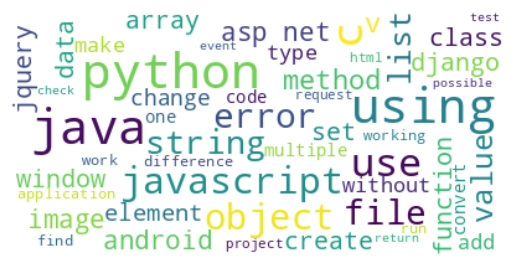

In [8]:
wordcloud_fig(df['Title'])

In [9]:

def common_rare_words(dataframe_col):

    cnt = Counter()
    for text in dataframe_col.values:
        for word in text.split():
            cnt[word] += 1
    temp_df = pd.DataFrame(cnt.most_common(), columns=["Word", "Freq"])
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    sns.barplot(data=temp_df.head(10), y="Word", x="Freq", ax=axes[0])
    axes[0].set_title("Boxplot")
    sns.barplot(data=temp_df.tail(10), y="Word", x="Freq", ax=axes[1])
    axes[1].set_title("Distplot")
    plt.suptitle(f"Distribution de {dataframe_col.name}", fontsize=22)
    plt.show()

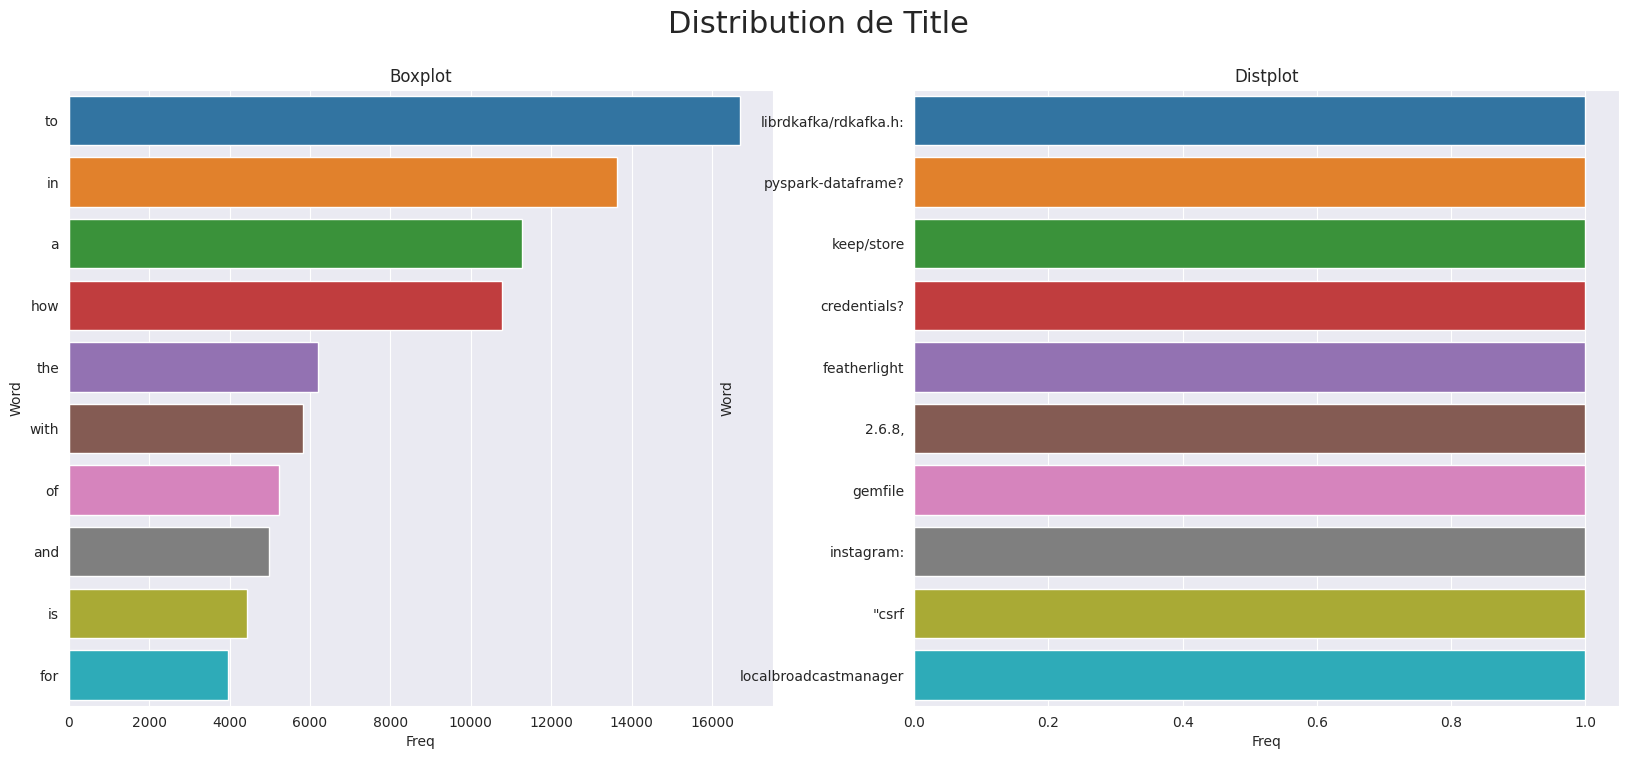

In [10]:
common_rare_words(df["Title"])

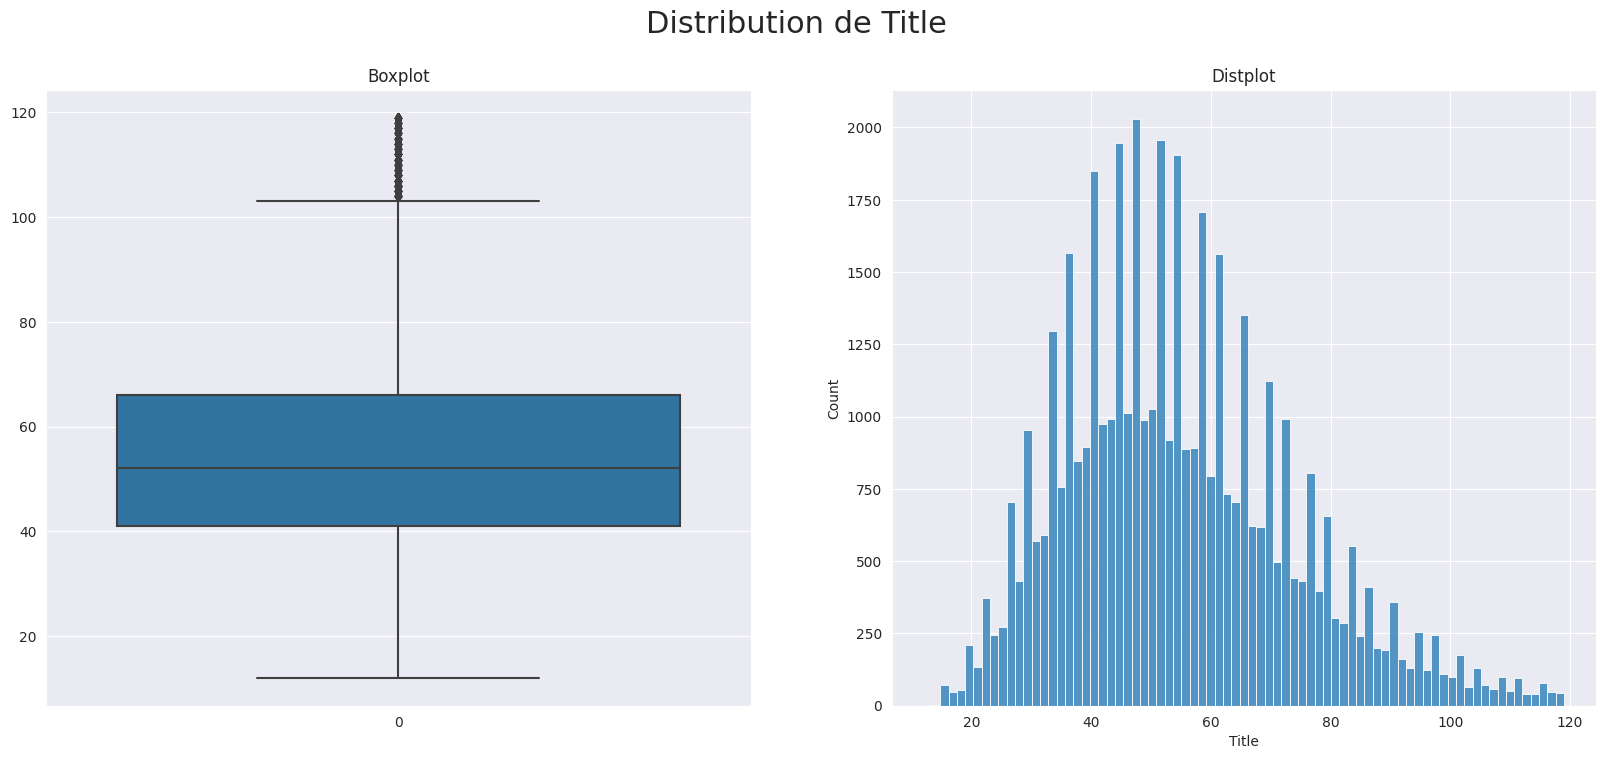

In [11]:
plot_words(df['Title'])

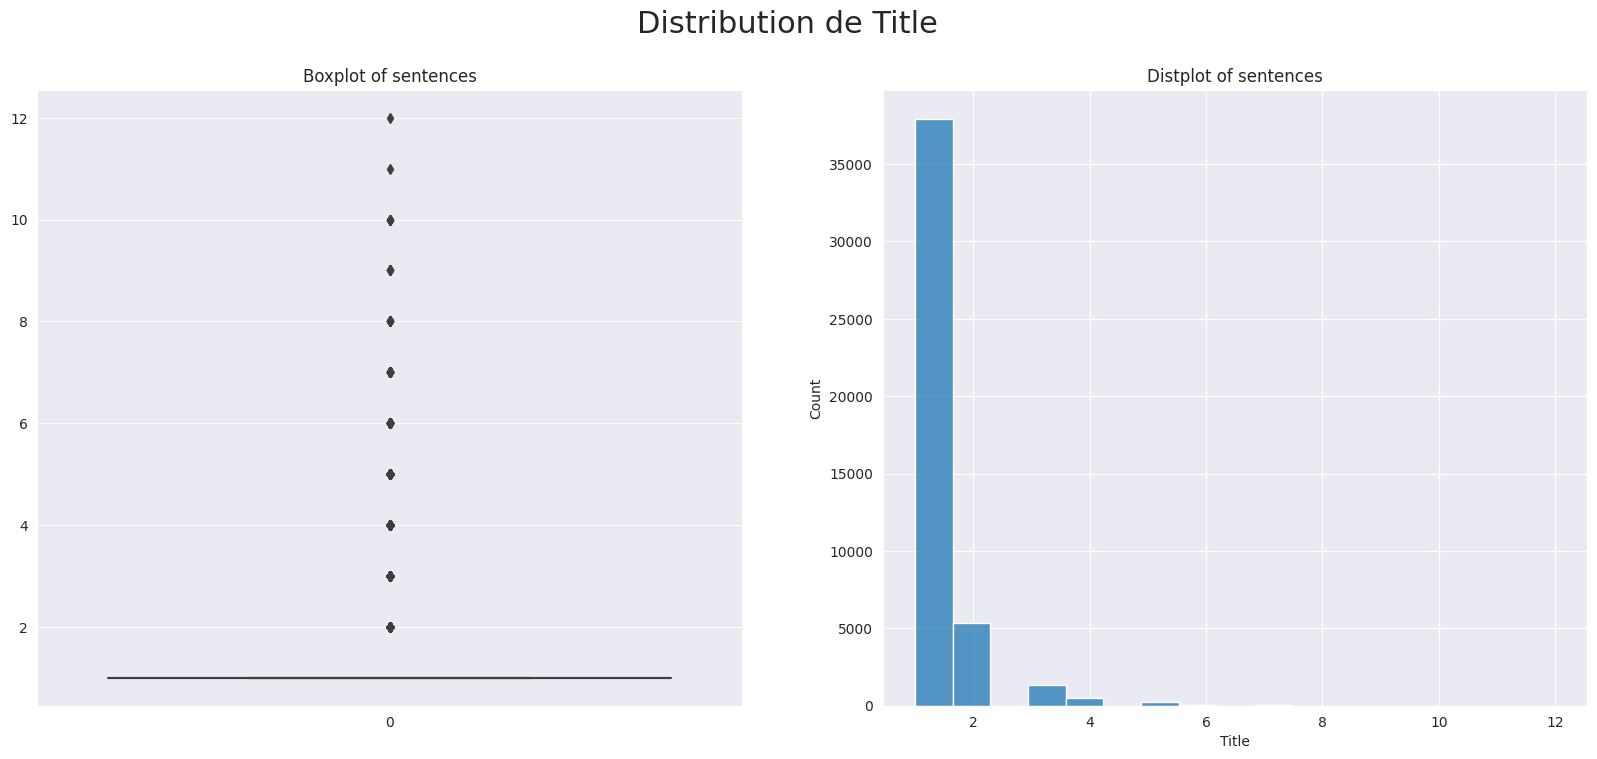

In [12]:
plot_sentences(df['Title'])

# Exploring Body

In [13]:
# making sure there is no duplicated
df.loc[ df['Body'].duplicated(keep=False), : ]

Empty DataFrame
Columns: [Title, Body, Id, Tags, Score, ViewCount, AnswerCount, FavoriteCount]
Index: []

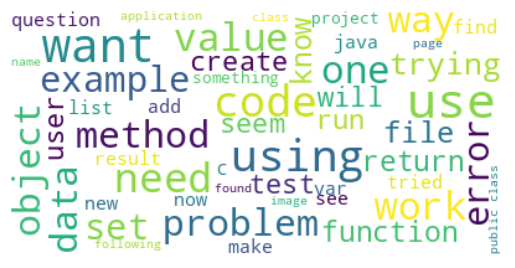

In [14]:
wordcloud_fig(df['Body'])

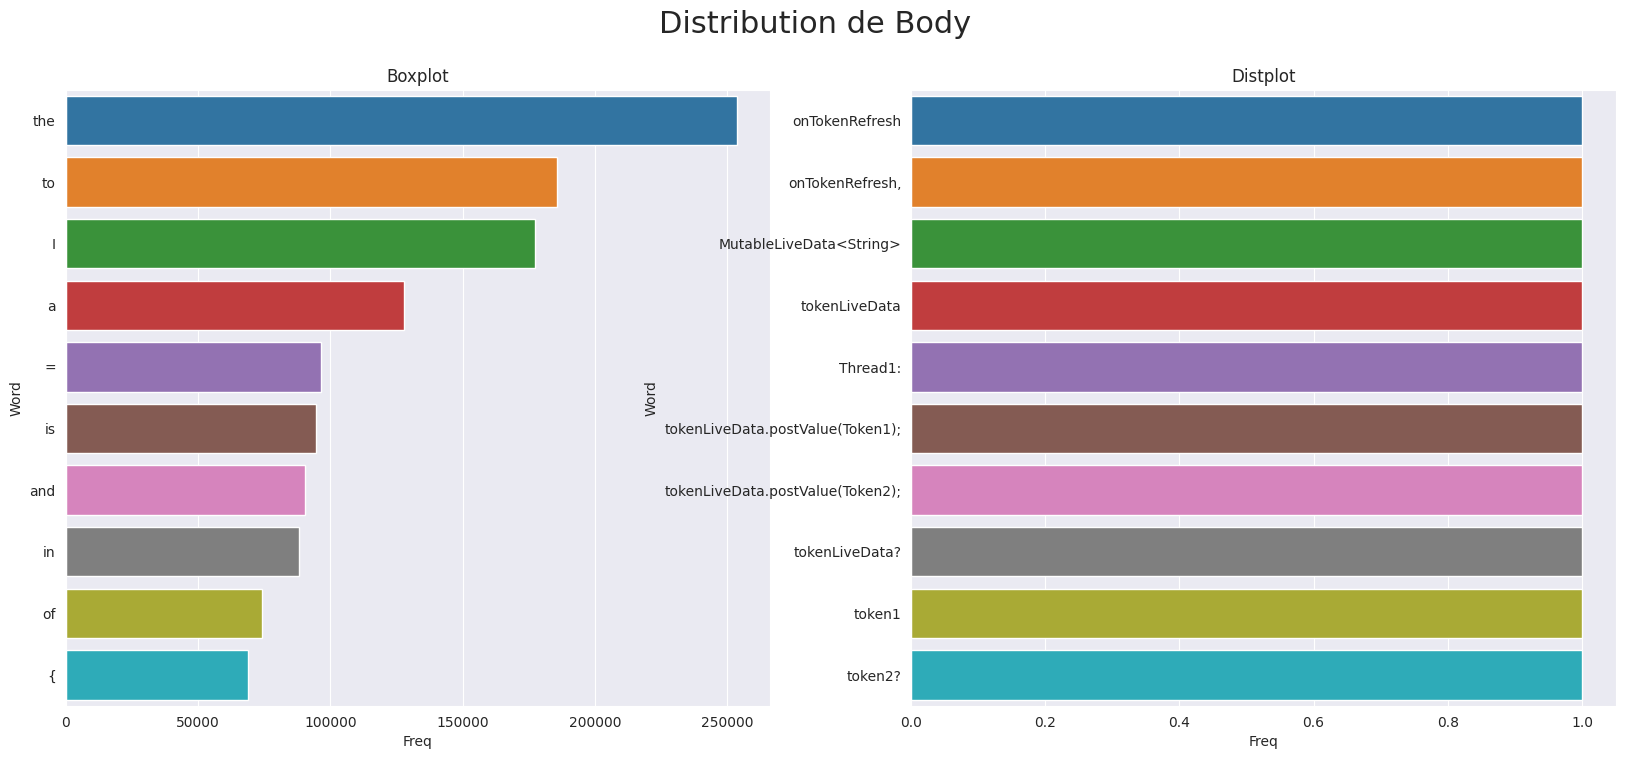

In [15]:
common_rare_words(df['Body'])

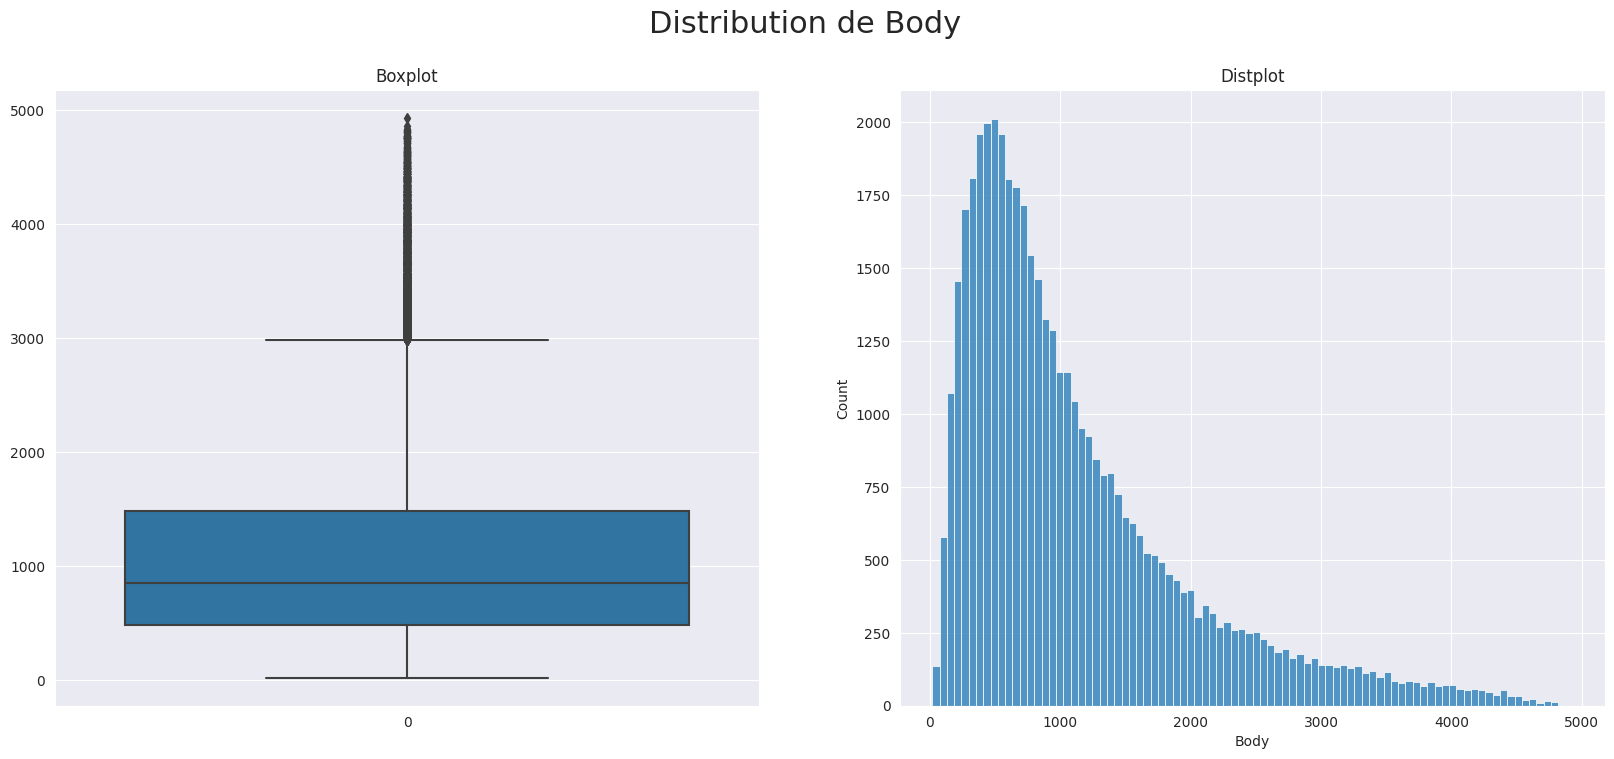

In [16]:
plot_words(df['Body'])

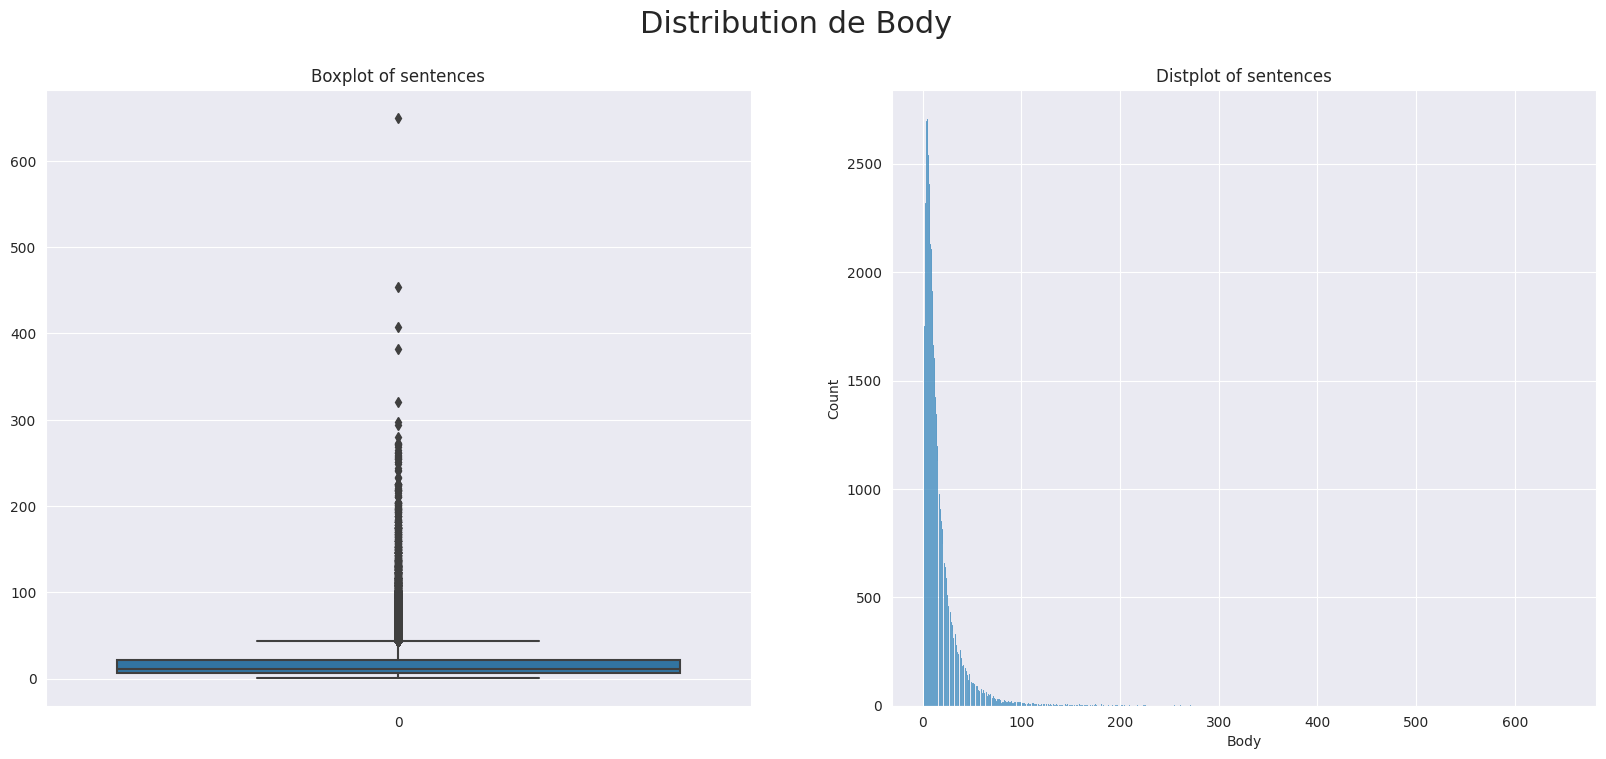

In [17]:
plot_sentences(df['Body'])

# Exploring tags

In [18]:
df.loc[df['Tags'].duplicated(keep=False), : ]

Title  \
82     generating a pdf document based on a microsoft...   
92     open a new javascript window(.open) along with...   
98             jquery focus out after pressing enter key   
112                               c# .net 3.5 gui design   
119                   when to use hibernate/jpa/toplink?   
...                                                  ...   
45455  how to disable bootstrap 4 validation style fr...   
45464      python opencv cv2 drawing rectangle with text   
45469  how to secure actuator endpoints with role in ...   
45476   how to make dispose await for all async methods?   
45477              inject generic interface in .net core   

                                                    Body        Id  \
82     I need to take a Word document that is a templ...     85404   
92     I'm trying to get this function to work on the...  18758288   
98     My code is below:\n$('.summaryT').keypress(fun...  18758469   
112    I'm looking for some programming guides to C# ...    121947   
119    Right now I'm making an extremely simple websi...    122571   
...                                                  ...       ...   
45455  I'm using bootstrap 4 styling for my applicati...  56075450   
45464  I draw a rectangle on my image using\ncv2.rect...  56108183   
45469  Can you help to secure actuator endpoints in S...  56117631   
45476  I have disposable class with async methods.\nc...  56138952   
45477  I want to inject this interface to my controll...  56143613   

                                                    Tags  Score  ViewCount  \
82                    c# .net asp.net pdf pdf-generation      8       9728   
92                   javascript jquery html css printing     30      77581   
98                        javascript php jquery html css     10      17410   
112                  c# .net wpf winforms user-interface      9       9030   
119                       java hibernate orm jpa toplink      7      21507   
...                                                  ...    ...        ...   
45455             javascript jquery html css bootstrap-4     16      17558   
45464  python image opencv image-processing computer-...     34      58837   
45469  java spring spring-boot spring-security spring...     10      13879   
45476    c# .net multithreading asynchronous async-await     11      12108   
45477  c# asp.net-core dependency-injection .net-core...     27      45154   

       AnswerCount  FavoriteCount  
82               7            NaN  
92               8            0.0  
98               4            0.0  
112              5            0.0  
119              6            0.0  
...            ...            ...  
45455            9            0.0  
45464            3            0.0  
45469            3            0.0  
45476            4            0.0  
45477            4            0.0  

[3241 rows x 8 columns]

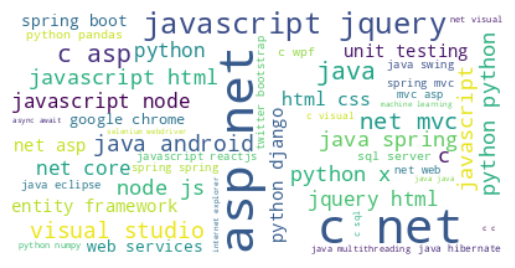

In [19]:
wordcloud_fig(df['Tags'])

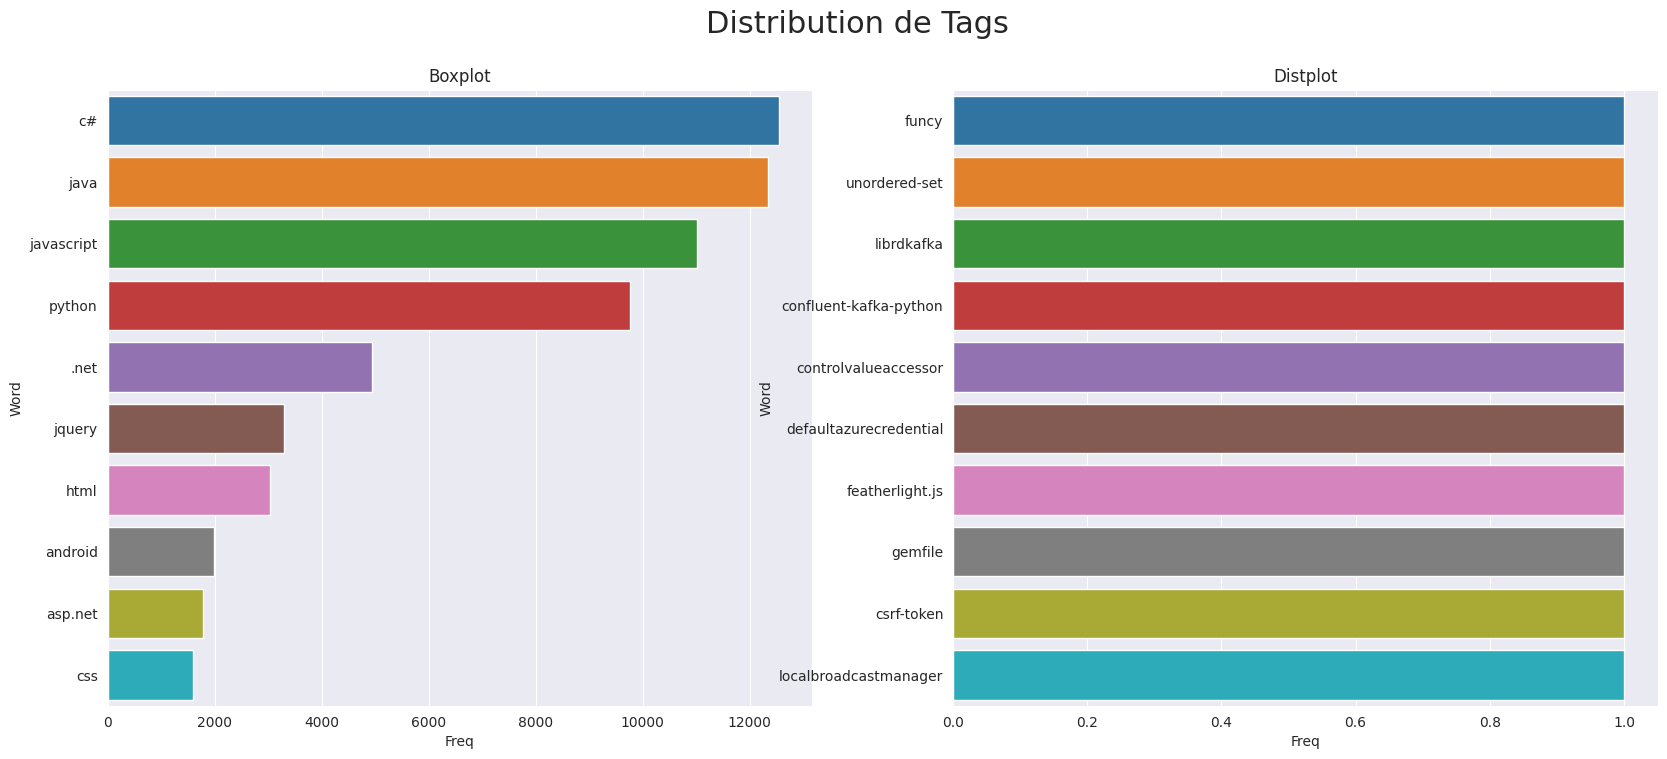

In [20]:
common_rare_words(df['Tags'])

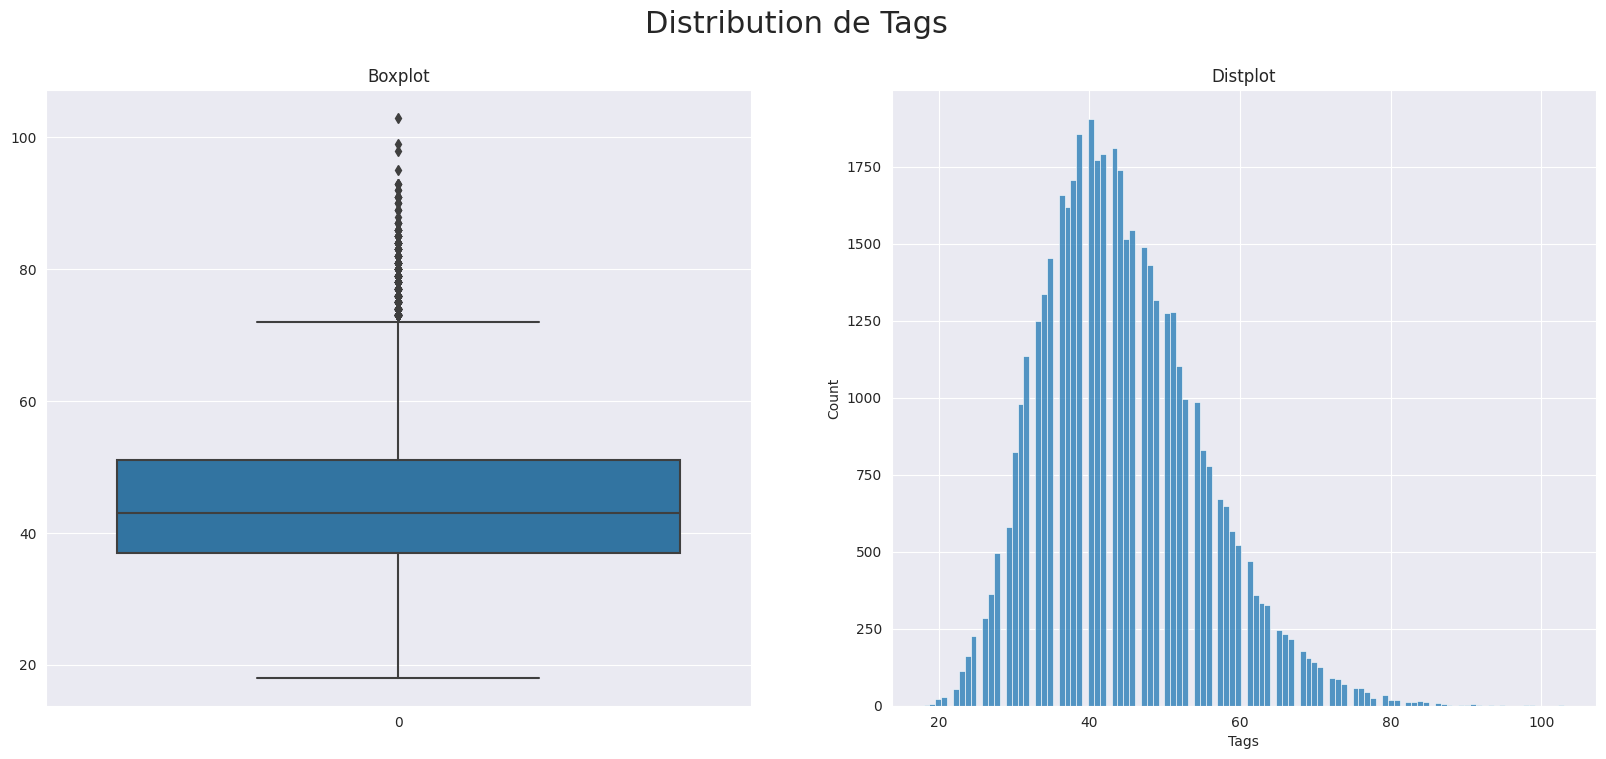

In [21]:
plot_words(df['Tags'])

In [22]:
df["Tags"]

0                          java .net axis2 ws-security wse
1                    javascript jquery sql html coldfusion
2        java collision-detection physics collision gam...
3               c# sql-server tsql ado.net sql-server-2000
4           java jakarta-ee amazon-ec2 cloud cloud-hosting
                               ...                        
45487         c# asp.net .net azure defaultazurecredential
45488         javascript html css lightbox featherlight.js
45489             javascript ios ruby react-native gemfile
45490      python python-3.x selenium instagram csrf-token
45491    java android broadcastreceiver android-service...
Name: Tags, Length: 45492, dtype: object

In [23]:
data = df.copy()

In [24]:
data['tag_count'] = data["Tags"].apply(lambda text: len(text.split(" ")))
data[data['tag_count'] > 5]
# data['l_t']

Title  \
961  show a different value from an input that what...   

                                                  Body        Id  \
961  I'd like to know if there is a way to show in ...  38227986   

                                          Tags  Score  ViewCount  AnswerCount  \
961  javascript php html input forms http-post     14      39721            4   

     FavoriteCount  tag_count  
961            0.0          6

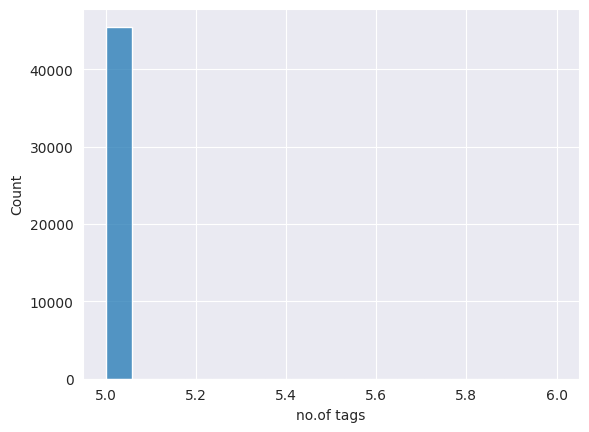

In [25]:
sns.histplot(data["tag_count"])
# plt.ylabel('no. of  ')
plt.xlabel('no.of tags')
plt.show()

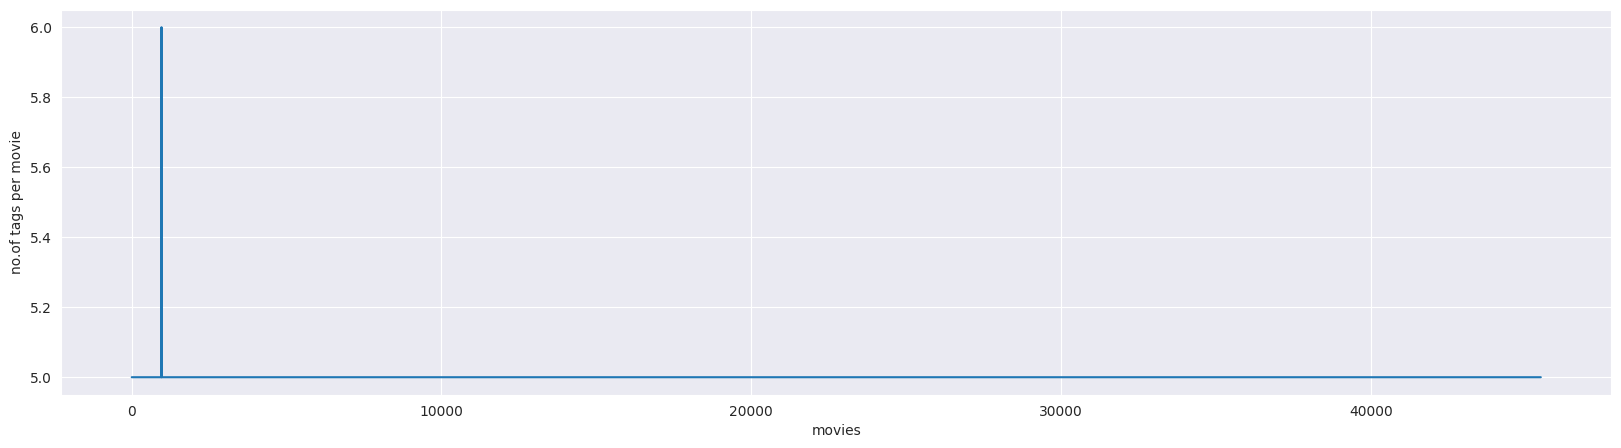

In [26]:
plt.figure(figsize=(20,5))
plt.plot(data["tag_count"])
plt.xlabel('movies')
plt.ylabel("no.of tags per movie")
plt.show()

/tmp/ipykernel_35777/2257023714.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data["tag_count"])


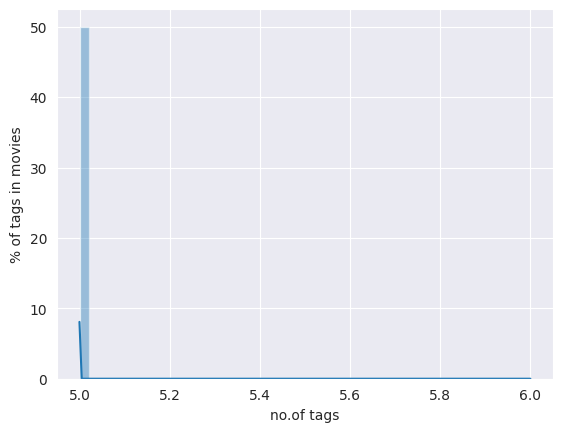

In [27]:
sns.distplot(data["tag_count"])
plt.ylabel('% of tags in movies')
plt.xlabel('no.of tags')
plt.show()

In [28]:
vectorizer = CountVectorizer(preprocessor=lambda x: x,tokenizer = lambda x: str(x).split(" ") )
tag_vect = vectorizer.fit_transform(data["Tags"])
def tags_to_choose(n):
    t = tag_vect.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn = tag_vect[:, sorted_tags_i[:n]]
    return multilabel_yn


def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x = multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x == 0))


# questions_explained = []
# total_tags = tag_vect.shape[1]
# total_qs = data.shape[0]
# for i in range(total_tags):
#     questions_explained.append(np.round(((total_qs - questions_explained_fn(i)) / total_qs) * 100, 3))
# fig, ax = plt.subplots()
# ax.plot(questions_explained)
# plt.xlabel("Number of tags")
# plt.ylabel("Number Questions coverd partially")
# plt.grid()
# plt.show()

/home/alex/Bureau/OpenClassroom/projet_5/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [29]:
data.groupby('Tags').count()

Title  Body  Id  Score  \
Tags                                                                         
.net .net-4.0 async-await c#-5.0 targeting              1     1   1      1   
.net asp.net javascript jquery jquery-ui                1     1   1      1   
.net asp.net-mvc asp.net-mvc-3 c#-4.0 razor             1     1   1      1   
.net assemblies com-interop javascript strongname       1     1   1      1   
.net asynchronous f# async-await c#-to-f#               1     1   1      1   
...                                                   ...   ...  ..    ...   
xml blackberry java-me sax kxml                         1     1   1      1   
xml digital-signature archiving java xml-signature      1     1   1      1   
xml eclipse spring warnings javabeans                   1     1   1      1   
xmlhttprequest jersey angularjs java-ee-6 cors          1     1   1      1   
youtube google-api youtube-api gdata youtube-ja...      1     1   1      1   

                                                    ViewCount  AnswerCount  \
Tags                                                                         
.net .net-4.0 async-await c#-5.0 targeting                  1            1   
.net asp.net javascript jquery jquery-ui                    1            1   
.net asp.net-mvc asp.net-mvc-3 c#-4.0 razor                 1            1   
.net assemblies com-interop javascript strongname           1            1   
.net asynchronous f# async-await c#-to-f#                   1            1   
...                                                       ...          ...   
xml blackberry java-me sax kxml                             1            1   
xml digital-signature archiving java xml-signature          1            1   
xml eclipse spring warnings javabeans                       1            1   
xmlhttprequest jersey angularjs java-ee-6 cors              1            1   
youtube google-api youtube-api gdata youtube-ja...          1            1   

                                                    FavoriteCount  tag_count  
Tags                                                                          
.net .net-4.0 async-await c#-5.0 targeting                      1          1  
.net asp.net javascript jquery jquery-ui                        0          1  
.net asp.net-mvc asp.net-mvc-3 c#-4.0 razor                     0          1  
.net assemblies com-interop javascript strongname               1          1  
.net asynchronous f# async-await c#-to-f#                       0          1  
...                                                           ...        ...  
xml blackberry java-me sax kxml                                 1          1  
xml digital-signature archiving java xml-signature              1          1  
xml eclipse spring warnings javabeans                           1          1  
xmlhttprequest jersey angularjs java-ee-6 cors                  1          1  
youtube google-api youtube-api gdata youtube-ja...              1          1  

[43405 rows x 8 columns]

Bag of words

In [30]:
from nltk import pos_tag, word_tokenize
import nltk

In [31]:
def remove_html_tags(text):
    return [BeautifulSoup(rmv_tag, "lxml").text for rmv_tag in text]#%%
import string
import pandas as pd
from collections import Counter
import numpy as np
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Import du dataset

In [32]:
df = pd.read_csv('./new_tags.csv')
df.rename(columns={'Unnamed: 0' : 'Title'}, inplace=True)
df.head(10)

Title  \
0  calling .net web service (wse 2/3, ws-security...   
1                    dynamic alphabetical navigation   
2  how to fix circle and rectangle overlap in col...   
3  how do you deal with transport-level errors in...   
4  how to deploy a java ee application in the ama...   
5  what is the equivalent of perl's (<>) in pytho...   
6      why declare a local function static in c# 8.0   
7  asp.net custom validator client side & server ...   
8                ruby equivalent for python's "try"?   
9               asp.net custom controls - composites   

                                                Body        Id  \
0  <p>I need to call a web service written in .NE...     16451   
1  <p>I'm using <code>ColdFusion</code> to return...     16458   
2  <p>Since in the digital world a real collision...  18704999   
3  <p>Every now and then in a high volume .NET ap...     16610   
4  <p>Here's the thing: I need to take a certain ...   4042477   
5  <p>In Perl one uses:</p>\n\n<pre><code>while (...   4554819   
6  <p>In C# 8.0, <a href="https://learn.microsoft...  58745614   
7  <p>This has not happened to me before, but for...    701029   
8  <p>I'm trying to convert some Python code into...  18705373   
9  <h2>Summary</h2>\n<p>Hi All,<br />\nOK, furthe...     17532   

                                                Tags  Score  ViewCount  \
0              <java><.net><axis2><ws-security><wse>     23      14052   
1        <javascript><jquery><sql><html><coldfusion>      9       3283   
2  <java><collision-detection><physics><collision...     10      12806   
3   <c#><sql-server><tsql><ado.net><sql-server-2000>     33      25173   
4  <java><jakarta-ee><amazon-ec2><cloud><cloud-ho...     22      19503   
5  <python><perl><file-io><file><command-line-arg...      7        881   
6        <c#><.net><static><c#-8.0><local-functions>     22       4658   
7   <c#><.net><asp.net><validation><customvalidator>     75     261598   
8  <python><python-3.x><ruby><try-catch><language...     72      47824   
9       <c#><.net><asp.net><user-controls><controls>     19       4164   

   AnswerCount  FavoriteCount  
0            5            0.0  
1            5            0.0  
2            3            0.0  
3           11            0.0  
4            3            0.0  
5            7            0.0  
6            4            0.0  
7            7            0.0  
8            3            0.0  
9            6            0.0

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45492 entries, 0 to 45491
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Title          45492 non-null  object 
 1   Body           45492 non-null  object 
 2   Id             45492 non-null  int64  
 3   Tags           45492 non-null  object 
 4   Score          45492 non-null  int64  
 5   ViewCount      45492 non-null  int64  
 6   AnswerCount    45492 non-null  int64  
 7   FavoriteCount  41165 non-null  float64
dtypes: float64(1), int64(4), object(3)
memory usage: 2.8+ MB


In [34]:
df.describe(include=[object])

Title  \
count                                               45492   
unique                                              45492   
top     calling .net web service (wse 2/3, ws-security...   
freq                                                    1   

                                                     Body  \
count                                               45492   
unique                                              45492   
top     <p>I need to call a web service written in .NE...   
freq                                                    1   

                                                     Tags  
count                                               45492  
unique                                              43405  
top     <javascript><jquery><html><css><twitter-bootst...  
freq                                                   68

# Utility function

In [35]:
def wordcloud_fig(text):
    wordcloud = WordCloud(max_font_size=40, max_words=50, background_color="white").generate(" ".join(i for i in text))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

def plot_words(col):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    sns.boxplot(data=col.str.len(), ax=axes[0])
    axes[0].set_title("Boxplot")
    sns.histplot(data=col.str.len(), ax=axes[1])
    axes[1].set_title("Distplot")
    plt.suptitle(f"Distribution de {col.name}", fontsize=22)
    plt.show()

def plot_sentences(col):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    sns.boxplot(data=col.str.split('.').str.len(), ax=axes[0])
    axes[0].set_title("Boxplot of sentences")
    sns.histplot(data=col.str.split('.').str.len(), ax=axes[1])
    axes[1].set_title("Distplot of sentences")
    plt.suptitle(f"Distribution de {col.name}", fontsize=22)
    plt.show()

def remove_html_tags(col):
    return [BeautifulSoup(rmv_tag, "lxml").text for rmv_tag in col]

# EDA avant traitement

## Nettoyage des tags html

In [36]:
df["Tags"] = df["Tags"].str.lstrip('<').str.replace('<', ' ').str.replace('>', '')
df['Body'] = remove_html_tags(df['Body'])

# Exploring Title

In [37]:
# making sure there is no duplicated
df.loc[ df['Title'].duplicated(keep=False), : ]

Empty DataFrame
Columns: [Title, Body, Id, Tags, Score, ViewCount, AnswerCount, FavoriteCount]
Index: []

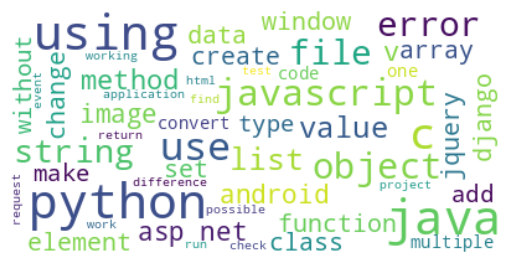

In [38]:
wordcloud_fig(df['Title'])

In [39]:

def common_rare_words(dataframe_col):

    cnt = Counter()
    for text in dataframe_col.values:
        for word in text.split():
            cnt[word] += 1
    temp_df = pd.DataFrame(cnt.most_common(), columns=["Word", "Freq"])
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    sns.barplot(data=temp_df.head(10), y="Word", x="Freq", ax=axes[0])
    axes[0].set_title("Boxplot")
    sns.barplot(data=temp_df.tail(10), y="Word", x="Freq", ax=axes[1])
    axes[1].set_title("Distplot")
    plt.suptitle(f"Distribution de {dataframe_col.name}", fontsize=22)
    plt.show()

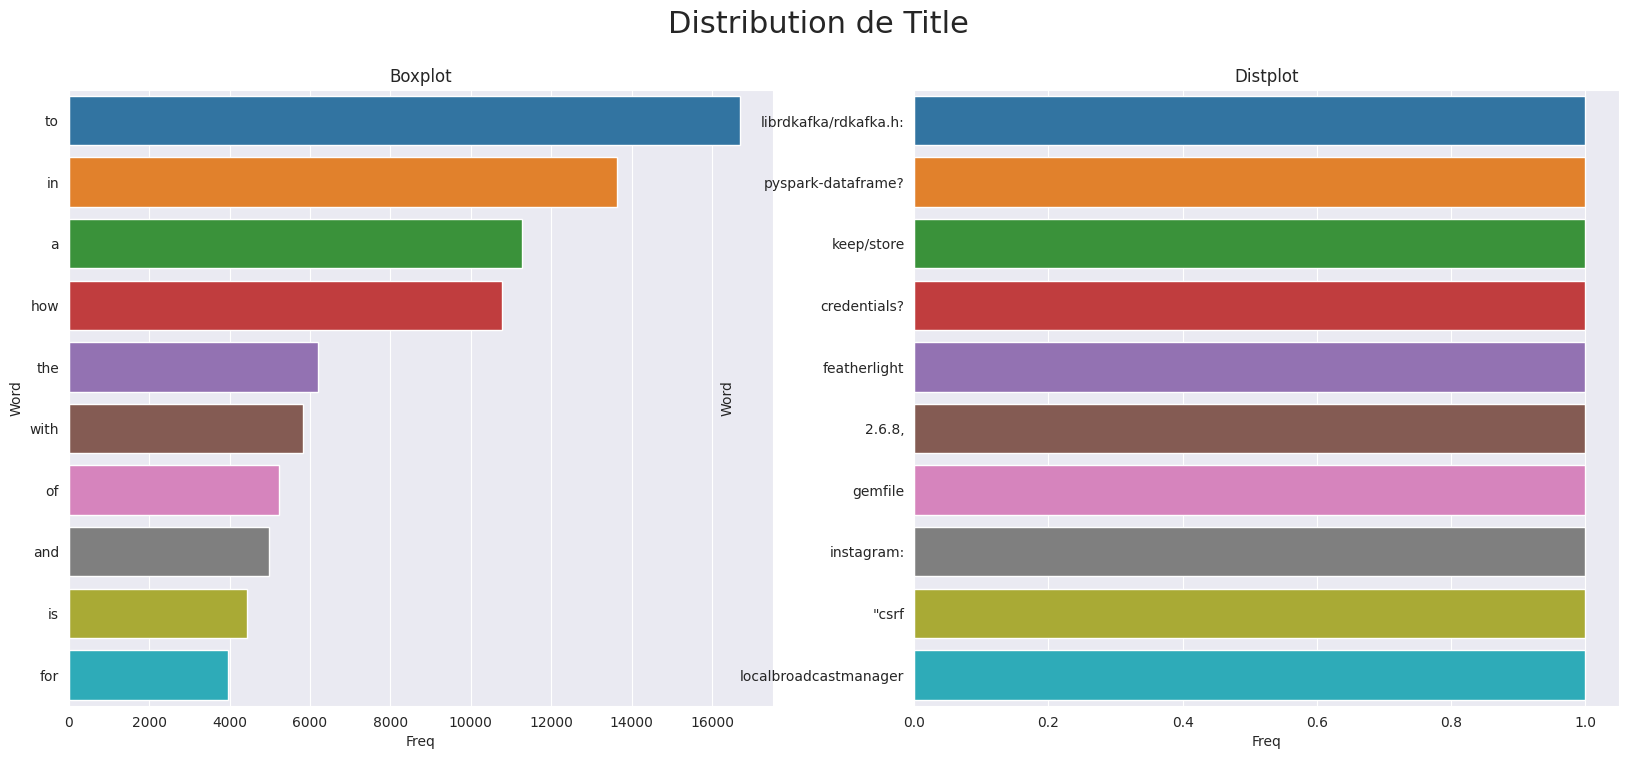

In [40]:
common_rare_words(df["Title"])

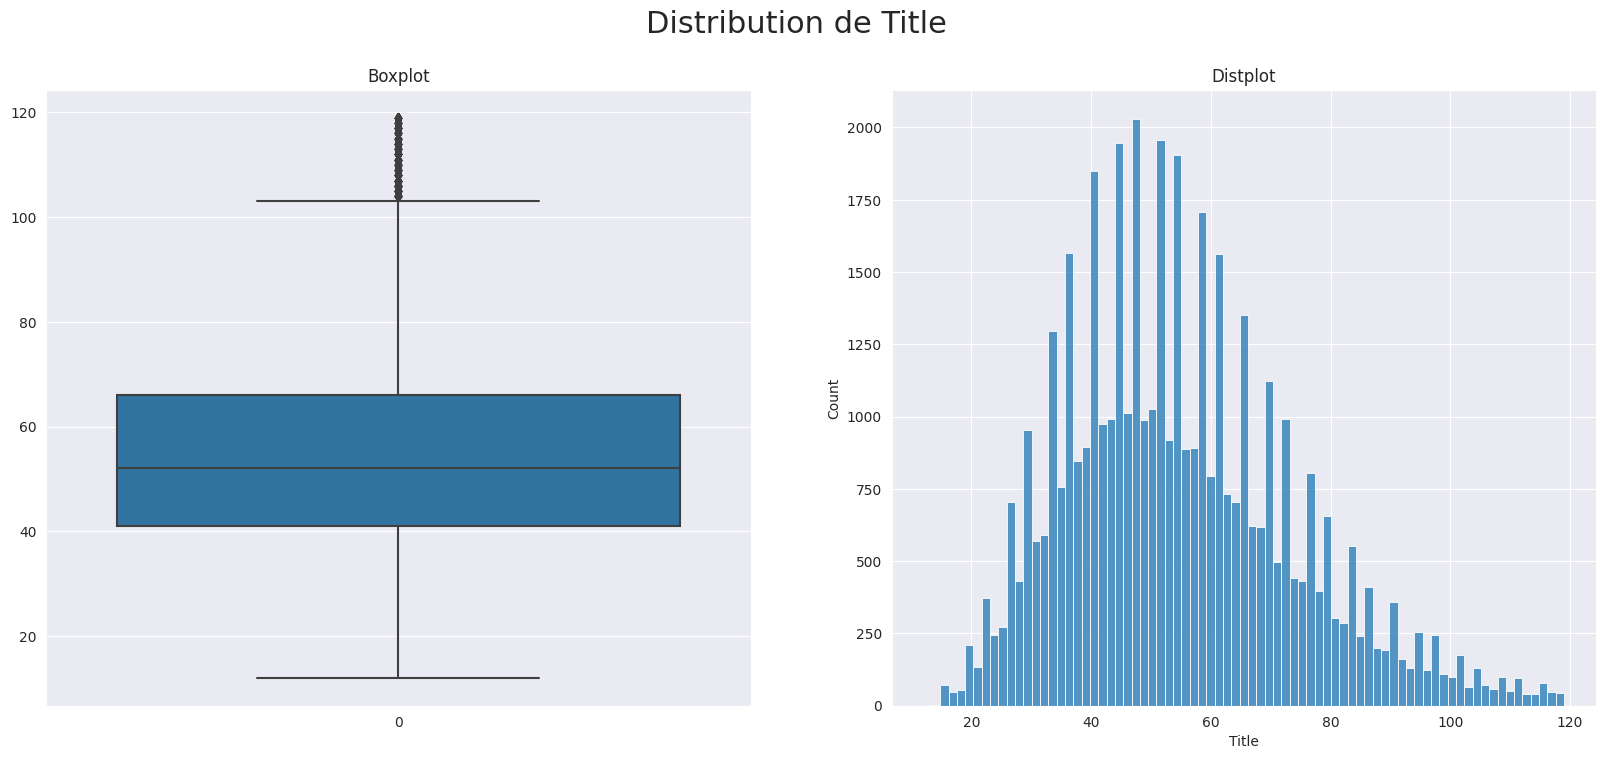

In [41]:
plot_words(df['Title'])

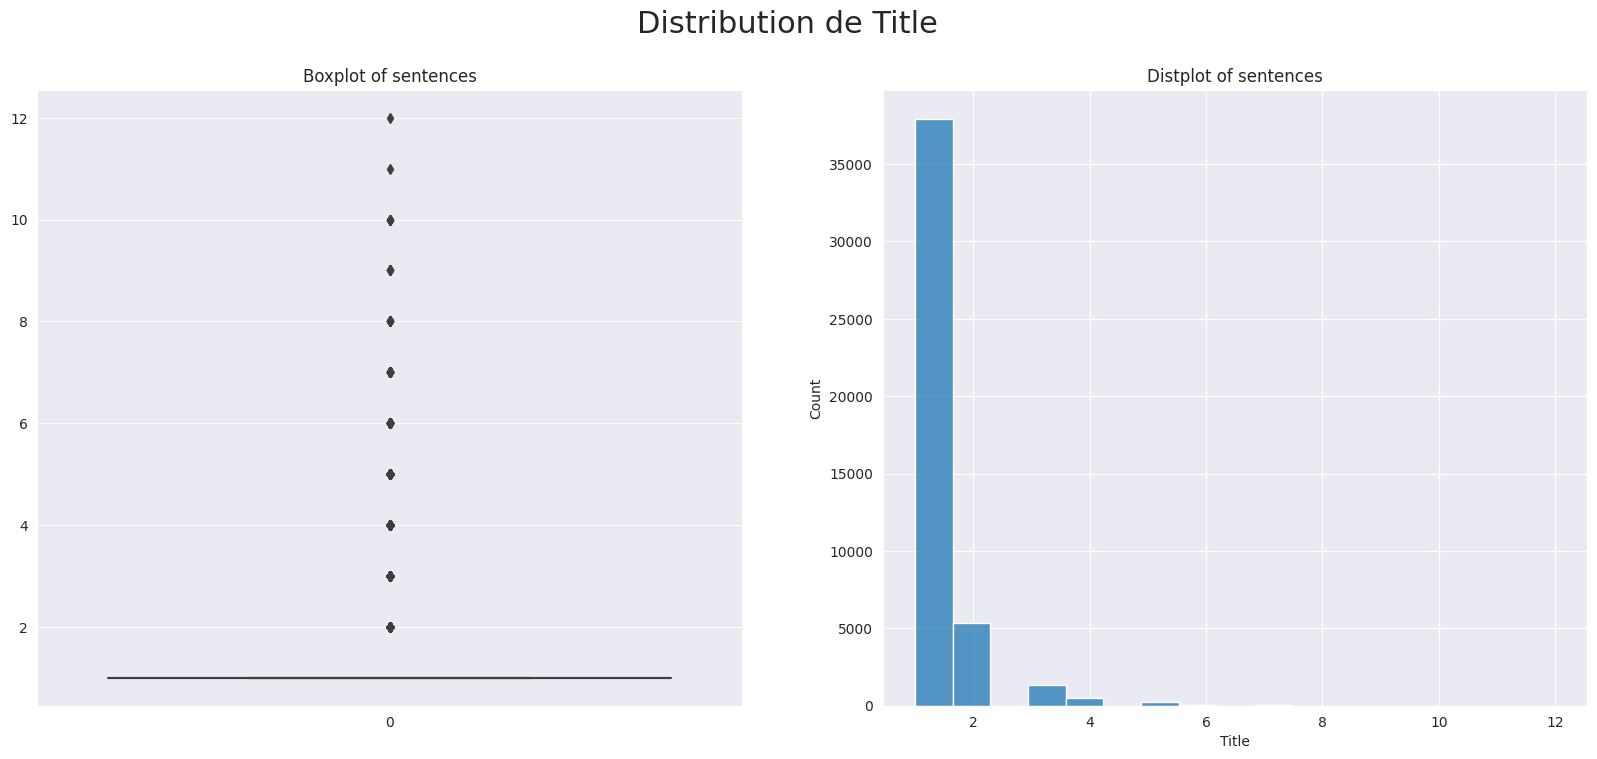

In [42]:
plot_sentences(df['Title'])

# Exploring Body

In [43]:
# making sure there is no duplicated
df.loc[ df['Body'].duplicated(keep=False), : ]

Empty DataFrame
Columns: [Title, Body, Id, Tags, Score, ViewCount, AnswerCount, FavoriteCount]
Index: []

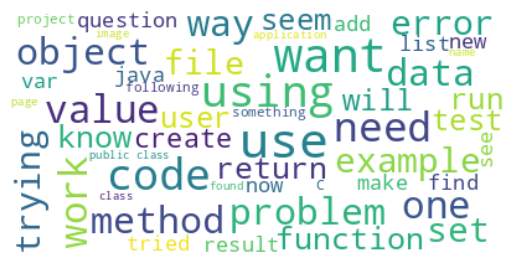

In [44]:
wordcloud_fig(df['Body'])

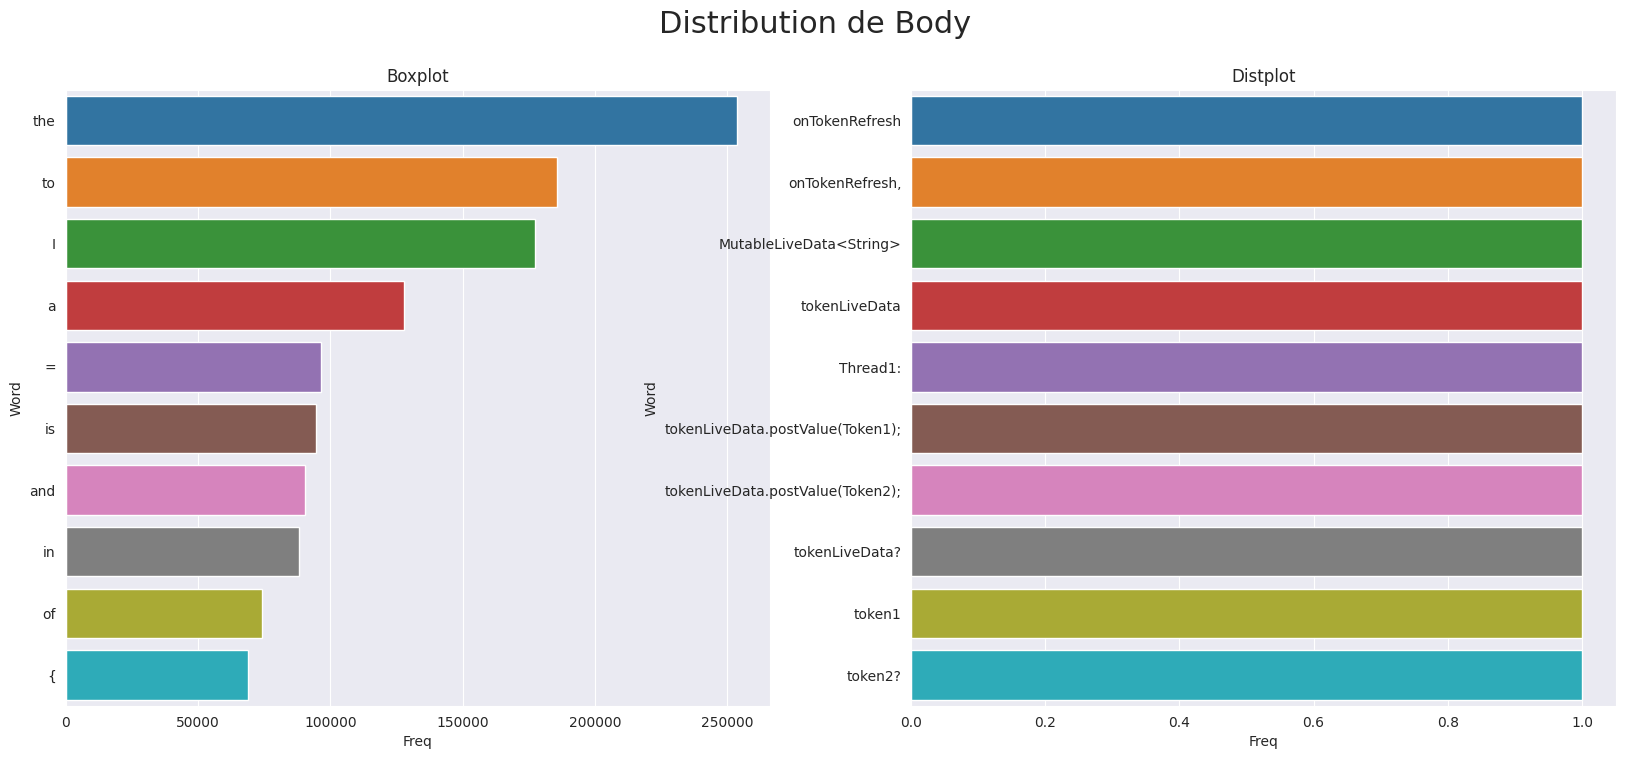

In [45]:
common_rare_words(df['Body'])

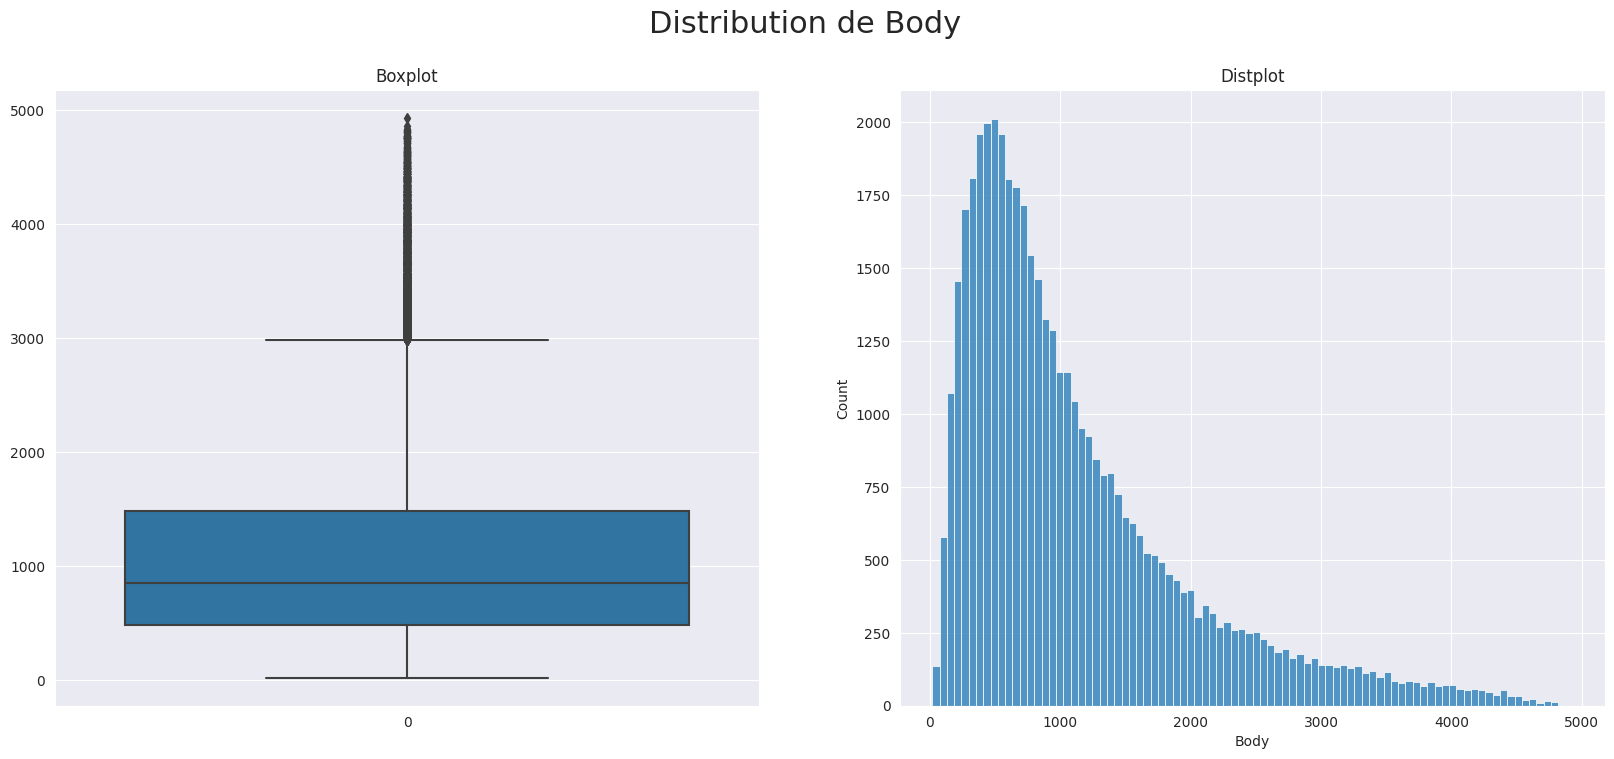

In [46]:
plot_words(df['Body'])

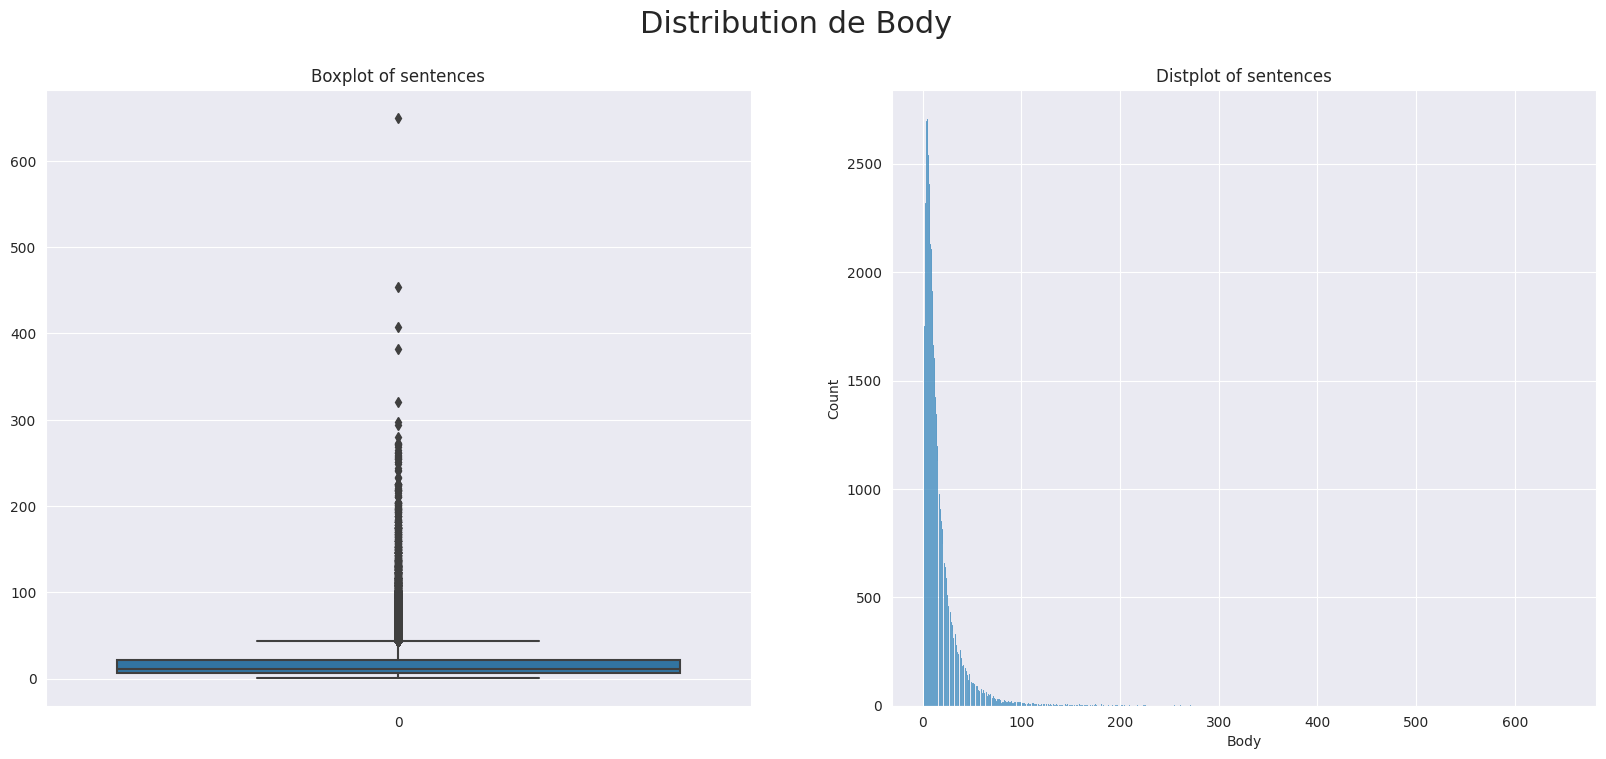

In [47]:
plot_sentences(df['Body'])

# Exploring tags

In [48]:
df.loc[df['Tags'].duplicated(keep=False), : ]

Title  \
82     generating a pdf document based on a microsoft...   
92     open a new javascript window(.open) along with...   
98             jquery focus out after pressing enter key   
112                               c# .net 3.5 gui design   
119                   when to use hibernate/jpa/toplink?   
...                                                  ...   
45455  how to disable bootstrap 4 validation style fr...   
45464      python opencv cv2 drawing rectangle with text   
45469  how to secure actuator endpoints with role in ...   
45476   how to make dispose await for all async methods?   
45477              inject generic interface in .net core   

                                                    Body        Id  \
82     I need to take a Word document that is a templ...     85404   
92     I'm trying to get this function to work on the...  18758288   
98     My code is below:\n$('.summaryT').keypress(fun...  18758469   
112    I'm looking for some programming guides to C# ...    121947   
119    Right now I'm making an extremely simple websi...    122571   
...                                                  ...       ...   
45455  I'm using bootstrap 4 styling for my applicati...  56075450   
45464  I draw a rectangle on my image using\ncv2.rect...  56108183   
45469  Can you help to secure actuator endpoints in S...  56117631   
45476  I have disposable class with async methods.\nc...  56138952   
45477  I want to inject this interface to my controll...  56143613   

                                                    Tags  Score  ViewCount  \
82                    c# .net asp.net pdf pdf-generation      8       9728   
92                   javascript jquery html css printing     30      77581   
98                        javascript php jquery html css     10      17410   
112                  c# .net wpf winforms user-interface      9       9030   
119                       java hibernate orm jpa toplink      7      21507   
...                                                  ...    ...        ...   
45455             javascript jquery html css bootstrap-4     16      17558   
45464  python image opencv image-processing computer-...     34      58837   
45469  java spring spring-boot spring-security spring...     10      13879   
45476    c# .net multithreading asynchronous async-await     11      12108   
45477  c# asp.net-core dependency-injection .net-core...     27      45154   

       AnswerCount  FavoriteCount  
82               7            NaN  
92               8            0.0  
98               4            0.0  
112              5            0.0  
119              6            0.0  
...            ...            ...  
45455            9            0.0  
45464            3            0.0  
45469            3            0.0  
45476            4            0.0  
45477            4            0.0  

[3241 rows x 8 columns]

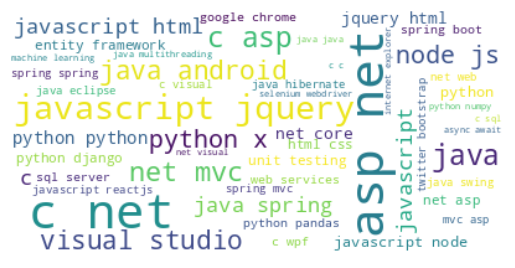

In [49]:
wordcloud_fig(df['Tags'])

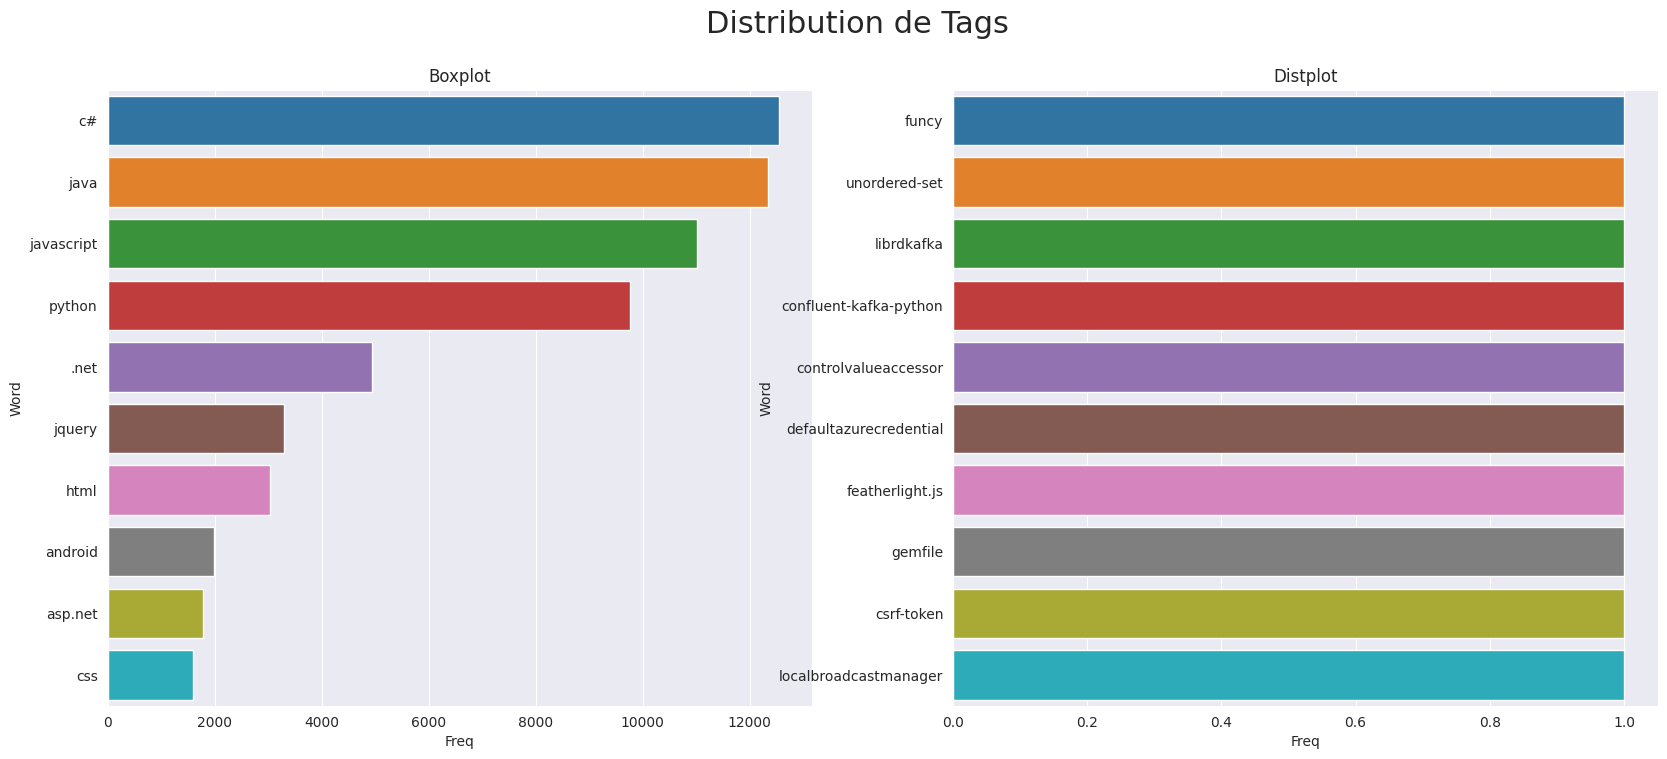

In [50]:
common_rare_words(df['Tags'])

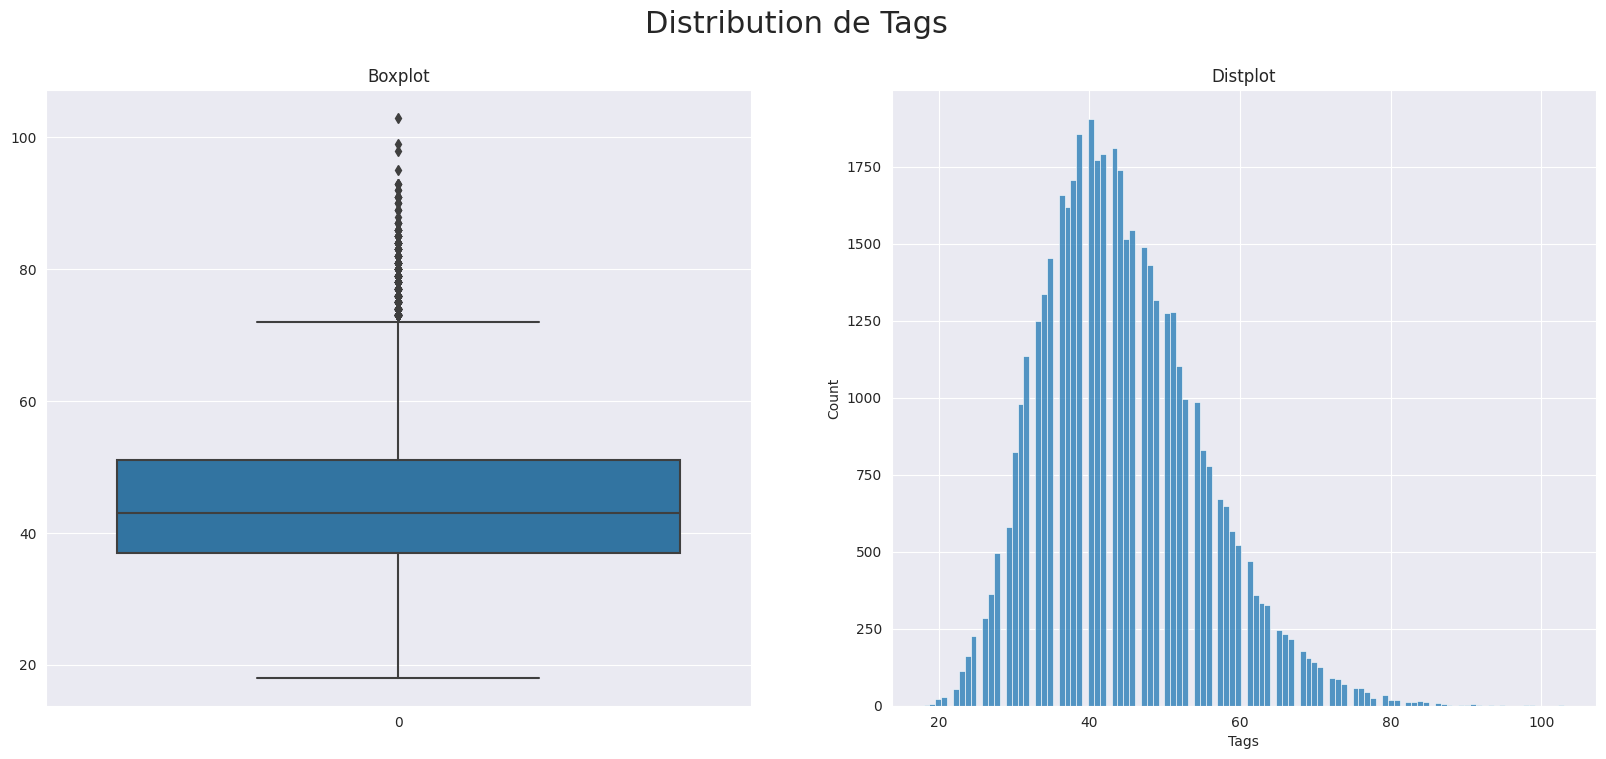

In [51]:
plot_words(df['Tags'])

In [52]:
df["Tags"]

0                          java .net axis2 ws-security wse
1                    javascript jquery sql html coldfusion
2        java collision-detection physics collision gam...
3               c# sql-server tsql ado.net sql-server-2000
4           java jakarta-ee amazon-ec2 cloud cloud-hosting
                               ...                        
45487         c# asp.net .net azure defaultazurecredential
45488         javascript html css lightbox featherlight.js
45489             javascript ios ruby react-native gemfile
45490      python python-3.x selenium instagram csrf-token
45491    java android broadcastreceiver android-service...
Name: Tags, Length: 45492, dtype: object

In [53]:
data = df.copy()

In [54]:
data['tag_count'] = data["Tags"].apply(lambda text: len(text.split(" ")))
data[data['tag_count'] > 5]
# data['l_t']

Title  \
961  show a different value from an input that what...   

                                                  Body        Id  \
961  I'd like to know if there is a way to show in ...  38227986   

                                          Tags  Score  ViewCount  AnswerCount  \
961  javascript php html input forms http-post     14      39721            4   

     FavoriteCount  tag_count  
961            0.0          6

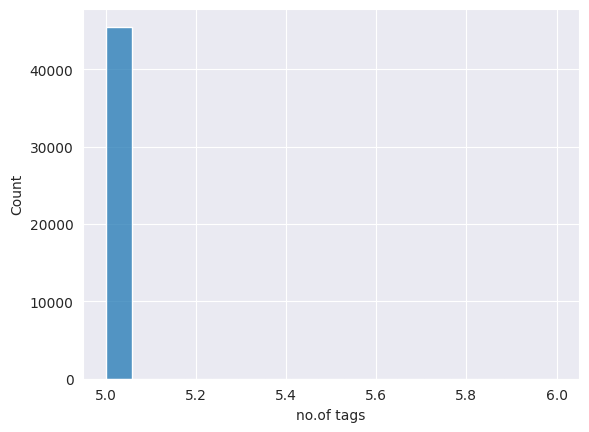

In [55]:
sns.histplot(data["tag_count"])
# plt.ylabel('no. of  ')
plt.xlabel('no.of tags')
plt.show()

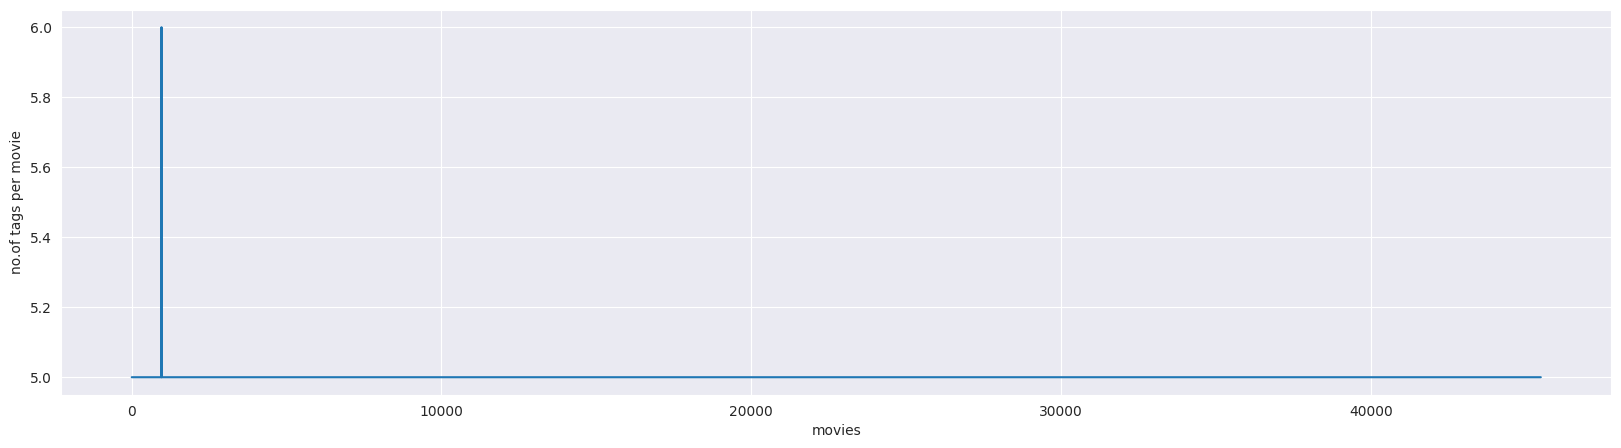

In [56]:
plt.figure(figsize=(20,5))
plt.plot(data["tag_count"])
plt.xlabel('movies')
plt.ylabel("no.of tags per movie")
plt.show()

/tmp/ipykernel_35777/2257023714.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data["tag_count"])


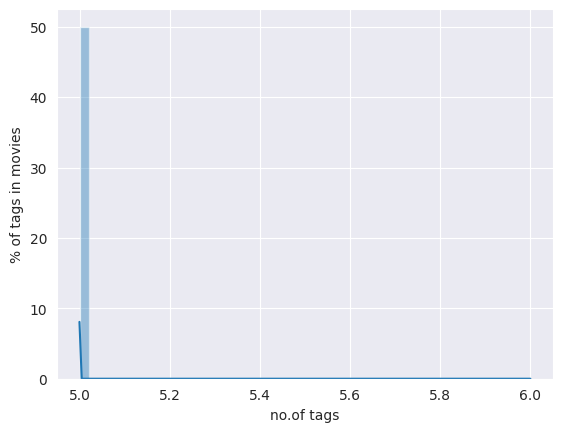

In [57]:
sns.distplot(data["tag_count"])
plt.ylabel('% of tags in movies')
plt.xlabel('no.of tags')
plt.show()

In [58]:
vectorizer = CountVectorizer(preprocessor=lambda x: x,tokenizer = lambda x: str(x).split(" ") )
tag_vect = vectorizer.fit_transform(data["Tags"])
def tags_to_choose(n):
    t = tag_vect.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn = tag_vect[:, sorted_tags_i[:n]]
    return multilabel_yn


def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x = multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x == 0))


# questions_explained = []
# total_tags = tag_vect.shape[1]
# total_qs = data.shape[0]
# for i in range(total_tags):
#     questions_explained.append(np.round(((total_qs - questions_explained_fn(i)) / total_qs) * 100, 3))
# fig, ax = plt.subplots()
# ax.plot(questions_explained)
# plt.xlabel("Number of tags")
# plt.ylabel("Number Questions coverd partially")
# plt.grid()
# plt.show()

/home/alex/Bureau/OpenClassroom/projet_5/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [59]:
data.groupby('Tags').count()

Title  Body  Id  Score  \
Tags                                                                         
.net .net-4.0 async-await c#-5.0 targeting              1     1   1      1   
.net asp.net javascript jquery jquery-ui                1     1   1      1   
.net asp.net-mvc asp.net-mvc-3 c#-4.0 razor             1     1   1      1   
.net assemblies com-interop javascript strongname       1     1   1      1   
.net asynchronous f# async-await c#-to-f#               1     1   1      1   
...                                                   ...   ...  ..    ...   
xml blackberry java-me sax kxml                         1     1   1      1   
xml digital-signature archiving java xml-signature      1     1   1      1   
xml eclipse spring warnings javabeans                   1     1   1      1   
xmlhttprequest jersey angularjs java-ee-6 cors          1     1   1      1   
youtube google-api youtube-api gdata youtube-ja...      1     1   1      1   

                                                    ViewCount  AnswerCount  \
Tags                                                                         
.net .net-4.0 async-await c#-5.0 targeting                  1            1   
.net asp.net javascript jquery jquery-ui                    1            1   
.net asp.net-mvc asp.net-mvc-3 c#-4.0 razor                 1            1   
.net assemblies com-interop javascript strongname           1            1   
.net asynchronous f# async-await c#-to-f#                   1            1   
...                                                       ...          ...   
xml blackberry java-me sax kxml                             1            1   
xml digital-signature archiving java xml-signature          1            1   
xml eclipse spring warnings javabeans                       1            1   
xmlhttprequest jersey angularjs java-ee-6 cors              1            1   
youtube google-api youtube-api gdata youtube-ja...          1            1   

                                                    FavoriteCount  tag_count  
Tags                                                                          
.net .net-4.0 async-await c#-5.0 targeting                      1          1  
.net asp.net javascript jquery jquery-ui                        0          1  
.net asp.net-mvc asp.net-mvc-3 c#-4.0 razor                     0          1  
.net assemblies com-interop javascript strongname               1          1  
.net asynchronous f# async-await c#-to-f#                       0          1  
...                                                           ...        ...  
xml blackberry java-me sax kxml                                 1          1  
xml digital-signature archiving java xml-signature              1          1  
xml eclipse spring warnings javabeans                           1          1  
xmlhttprequest jersey angularjs java-ee-6 cors                  1          1  
youtube google-api youtube-api gdata youtube-ja...              1          1  

[43405 rows x 8 columns]

Bag of words

# Pre-processing the dataset

## Column Title

In [60]:
from nltk import pos_tag, word_tokenize
import nltk
import contractions

In [61]:
def remove_html_tags(text):
    return [BeautifulSoup(rmv_tag, "lxml").text for rmv_tag in text]

# def remove_aplhanum(text):
#     rx = re.compile(r'[^a-zA-Z]')
#     # return [rx.sub("", word) for word in text]
#     pattern = r'[^a-zA-z.,!?/:;\"\'\s]'
#     return re.sub(pattern, '', text)

def remove_punctuation(text):
    return text.translate(str.maketrans("", "", string.punctuation))

In [62]:
def decontracted_text(text):
    return contractions.fix(text)


def remove_punctuations(text):
    remove = string.punctuation
    remove = remove.replace("#", "") # don't c#
    # remove = remove.replace("'", "")
    remove = remove.replace("+", "") # don't remove c++
    pattern = r"[{}](?!net)".format(re.escape(remove))
    return re.sub(pattern, "", text)


def word_lemmatizer(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    # return [wordnet_lemmatizer.lemmatize(word, pos="v") for word in text]
    # return ' '.join([wordnet_lemmatizer.lemmatize(w, pos="v") for w in word_tokenize(text)])
    return ' '.join([wordnet_lemmatizer.lemmatize(w, pos="v") for w in text.split()])



def remove_aplhanum(text):
    return ''.join(i for i in text if not i.isdigit())


def remove_stopwords_nltk(text):
    # [w for w in text if w not in stopwords.words("english")]
    # x = [w for w in text if w not in stopwords.words("english")]
    # return text if word_tokenize(text) not in stopwords.words("english") else ""
    # return ' '.join([w for w in word_tokenize(text) if w not in stopwords.words("english")])
    return ' '.join([w for w in text.split() if w not in stopwords.words("english")])

In [63]:
data["Title"]

0        calling .net web service (wse 2/3, ws-security...
1                          dynamic alphabetical navigation
2        how to fix circle and rectangle overlap in col...
3        how do you deal with transport-level errors in...
4        how to deploy a java ee application in the ama...
                               ...                        
45487            how do i keep/store my azure credentials?
45488                responsive featherlight iframes width
45489    your ruby version is 2.6.8, but your gemfile s...
45490    i can't log in to instagram: "csrf token missi...
45491    localbroadcastmanager is now deprecated, how t...
Name: Title, Length: 45492, dtype: object

In [64]:
SEED = 42

In [65]:
data["Title"] = data["Title"].apply(lambda x :decontracted_text(x))

In [66]:
data["Title"] = data["Title"].apply(lambda x : remove_punctuations(x))

In [67]:
data["Title"] = data["Title"].apply(lambda x : remove_aplhanum(x))

In [68]:
data["Title"] = data["Title"].apply(lambda x : remove_stopwords_nltk(x))

In [69]:
data["Title"] = data["Title"].apply(lambda x : word_lemmatizer(x))

In [70]:
X = data["Title"]

In [71]:
X

0                call .net web service wse wssecurity java
1                          dynamic alphabetical navigation
2          fix circle rectangle overlap collision response
3                 deal transportlevel errors sqlconnection
4                  deploy java ee application amazon cloud
                               ...                        
45487                          keepstore azure credentials
45488                responsive featherlight iframes width
45489                         ruby version gemfile specify
45490       cannot log instagram csrf token miss incorrect
45491    localbroadcastmanager deprecate send data serv...
Name: Title, Length: 45492, dtype: object

In [72]:
# y = mlb.fit_transform(data["Tags"].apply(lambda x: x.split(" ")))
X_train, X_test = train_test_split(
    X, test_size=0.25, random_state=SEED
)
# print(X_train.shape, X_test.shape)

In [73]:
vectorizer = CountVectorizer()
vector = vectorizer.fit_transform(X_train)
vector.shape

(34119, 17069)

In [1]:
t = pd.DataFrame(vector.toarray(), columns=vectorizer.get_feature_names_out())
t.head().iloc[: , 99:1000]

NameError: name 'pd' is not defined

In [ ]:
t.head(1).stack()[t.stack() > 0.]